# Calculation of enhancement factor E
***
* Author: Yannick E. Heiser
* Email:  wfg813@alumni.ku.dk
* Last updated:   23th of April 2023
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 35
plt.rcParams['font.size'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['legend.fontsize'] = 30
from scipy.ndimage import gaussian_filter1d
import sys
import glob
import os
from tkinter import Tcl
from os.path import join
from skimage import io

saveplot = True

### 1. Read in data from csv

In [2]:
def read_csv(path):
    """
    read in csv files with grain size data and put it in dict of dataframes
    --------------------------------------
    param: (str) path: path of csv files
    """
    df = {}
    if path != None:
        os.chdir(path)    
    files = glob.glob("*.csv")
    files = Tcl().call('lsort', '-dict', files) #sort csv files after name
    for i in range(len(files)):
        file = files[i]
        bag = file[:-4]
        df[bag] = pd.read_csv(file)
    os.chdir("/home/jovyan/work/Master Thesis")
    return df

In [3]:
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/grain_sizes_depth/10mm_intervall"
df_xLASM = read_csv(file_path)
df_xLASM["nmx3676c"].head(5)

,crop_image,depth[m],equivalent_diameter[px],grain_size[px],grain_size_err[px]
0,0,2021.2505,244.304540,1.937896e+06,0
1,0,2021.2515,276.217056,2.369657e+06,0
2,0,2021.2525,273.532315,2.304709e+06,0
3,0,2021.2535,285.619165,2.446542e+06,0
4,0,2021.2545,273.701733,2.242376e+06,0


### 2. Smoothing of data

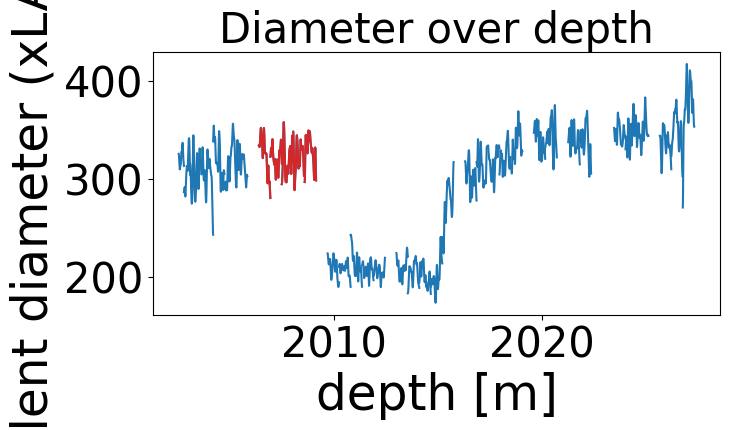

In [4]:
smoothing = True

# Plot grain sizes over depth of all images
fig, ax = plt.subplots(1, 1,figsize=(8,5))
ax.ticklabel_format(useOffset=False,style='plain')
for bag in list(df_xLASM.keys()):
    if smoothing:
        diameter_smooth = gaussian_filter1d(df_xLASM[bag]["equivalent_diameter[px]"], 20)
    else:
        diameter_smooth = df_xLASM[bag]["equivalent_diameter[px]"]
    ax.plot(df_xLASM[bag]["depth[m]"],diameter_smooth,"-",color="tab:blue")
for bag in list(df_xLASM.keys())[7:-25]:
    if smoothing:
        diameter_smooth = gaussian_filter1d(df_xLASM[bag]["equivalent_diameter[px]"], 20)
    else:
        diameter_smooth = df_xLASM[bag]["equivalent_diameter[px]"]
    ax.plot(df_xLASM[bag]["depth[m]"],diameter_smooth,"-",color="tab:red",label=bag)
#ax.legend()
ax.set(title="Diameter over depth",xlabel="depth [m]",ylabel="equivalent diameter (xLASM) [px]")
fig.tight_layout()
if saveplot:
    fig.savefig("Plots/18_diameter_vs_depth.png",dpi=100)
fig.show()

### 3. Calculation of E following
$$ E = \frac{\dot{\varepsilon}_{GBS}}{\dot{\varepsilon}_{GBS,d=const}} = \frac{A_0\tau^nd^{-p}exp\left(-\frac{Q+PV}{RT}\right)}{A_0\tau^nd_{const}^{-p}exp\left(-\frac{Q+PV}{RT}\right)} = \frac{d_{const}^p}{d^p} $$

In [5]:
# create mean of red marked stadial bags
px_to_m = 1/200000 #1px = 1/200000m
diameters = np.array([])
for bag in list(df_xLASM.keys())[7:-25]:
    diameters = np.concatenate((diameters,gaussian_filter1d(np.array(df_xLASM[bag]["equivalent_diameter[px]"]),30)))
diameter_mean = np.mean(diameters)*px_to_m
diameter_mean

0.0016146222586587364

In [6]:
# Load interpolated CFA
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/Linescan_gray_values_interpolated/"
path = file_path + "gray_interpolated.csv"

gray_interp = pd.read_csv(path)
gray_interp.head()

,depth[m],gray_value,gray_value_err
0,2002.556,36.016062,16.138655
1,2002.557,32.573303,14.858734
2,2002.558,30.686754,14.663540
3,2002.559,28.235302,14.862442
4,2002.560,25.326288,13.658646


In [7]:
# Calculating E
for bag in list(df_xLASM.keys()):
    if smoothing:
        df_xLASM[bag]["E_1"] = diameter_mean**1.4/((gaussian_filter1d(df_xLASM[bag]["equivalent_diameter[px]"],30)*px_to_m)**1.4)
    else:
        df_xLASM[bag]["E_1"] = diameter_mean**1.4/((df_xLASM[bag]["equivalent_diameter[px]"]*px_to_m)**1.4)

In [8]:
# Load interpolated CFA data
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/CFA_interpolated/"

path = file_path + "CFA_interpolated.csv"
CFA_interp_slic = pd.read_csv(path)
CFA_interp_slic.head()

,Depth top (m),Cond (mikroS/cm),Na+ (ng/g),Ca++ (ng/g),Dust (#/mL) [SD>1.0],NH4+ (ng/g),NO3- (ng/g),H2O2 (ng/g),age (yr b2k)
0,2002.551,1.044638,35.386801,55.215085,12756.954682,1.126816,64.802555,NaN,71186.178182
1,2002.552,1.053359,34.908770,55.349388,12533.003895,1.146882,64.671126,NaN,71186.356364
2,2002.553,1.062309,34.420666,55.475033,12295.928952,1.166981,64.537724,NaN,71186.534545
3,2002.554,1.071514,33.925007,55.593180,12045.890426,1.187068,64.403140,NaN,71186.712727
4,2002.555,1.081003,33.424313,55.704991,11783.048888,1.207099,64.268160,NaN,71186.890909


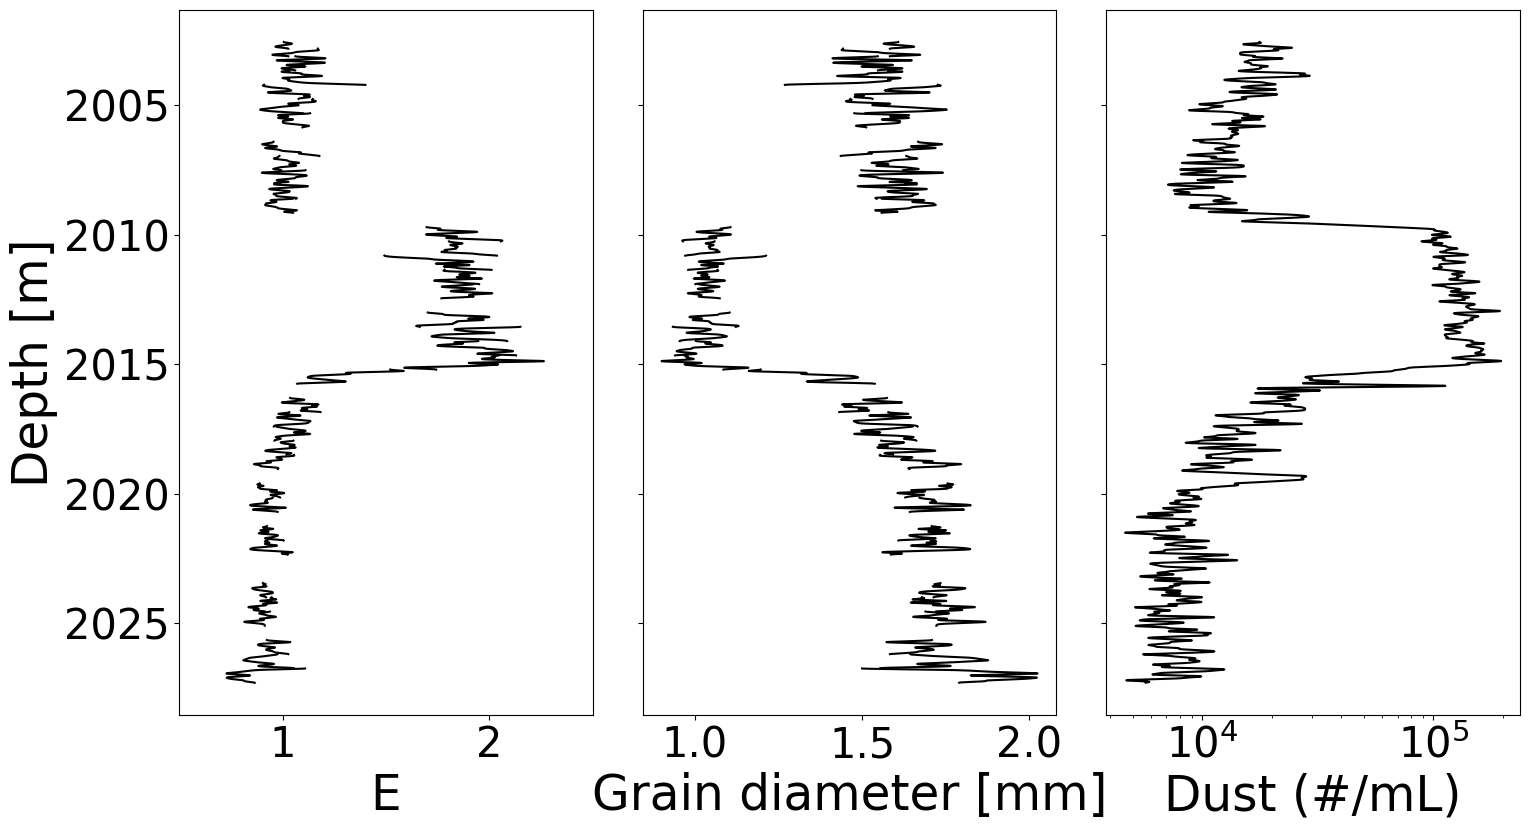

In [9]:
# Plot grain sizes over depth of all images
fig, ax = plt.subplots(1, 3,figsize=(16,9),sharey=True)
#ax2 = ax[2].twiny()
for bag in list(df_xLASM.keys()):
    ax[0].plot(df_xLASM[bag]["E_1"],df_xLASM[bag]["depth[m]"],"-",color="black")
    ax[1].plot(gaussian_filter1d(df_xLASM[bag]["equivalent_diameter[px]"]*px_to_m*1000,30),df_xLASM[bag]["depth[m]"],"-",color="black")
#ax[2].plot(gaussian_filter1d(gray_interp["gray_value"],30),gray_interp["depth[m]"],"-",color="black")
ax[2].semilogx(gaussian_filter1d(CFA_interp_slic["Dust (#/mL) [SD>1.0]"],30),CFA_interp_slic["Depth top (m)"],color="black")

ax[0].set(ylabel="Depth [m]",xlabel="E",xlim=(0.5,2.5))
ax[1].set_xlabel("Grain diameter [mm]")
ax[2].set_xlabel("Dust (#/mL)")
#ax[2].set_xticks([])
#ax2.set_xticks([])

#ax[1].set_yticks([], [])
#ax[2].set_yticks([], [])
fig.gca().invert_yaxis()
fig.tight_layout()
if saveplot:
    fig.savefig("Plots/18_E_gbs_gbs.png",dpi=100)
fig.show()

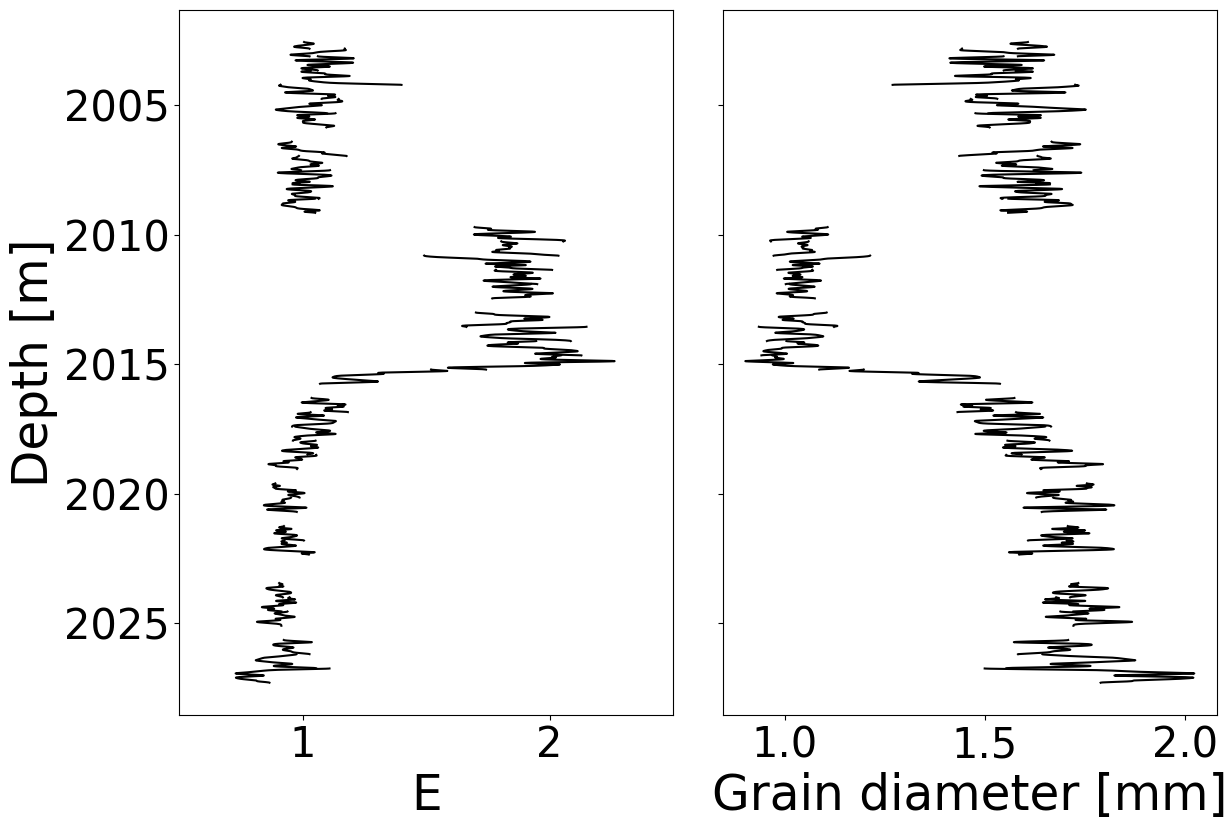

In [10]:
# Plot grain sizes over depth of all images
fig, ax = plt.subplots(1, 2,figsize=(13,9),sharey=True)
for bag in list(df_xLASM.keys()):
    ax[0].plot(df_xLASM[bag]["E_1"],df_xLASM[bag]["depth[m]"],"-",color="black")
    ax[1].plot(gaussian_filter1d(df_xLASM[bag]["equivalent_diameter[px]"]*px_to_m*1000,30),df_xLASM[bag]["depth[m]"],"-",color="black")

ax[0].set(ylabel="Depth [m]",xlabel="E",xlim=(0.5,2.5))
ax[1].set_xlabel("Grain diameter [mm]")

fig.gca().invert_yaxis()
fig.tight_layout()
if saveplot:
    fig.savefig("Plots/18_E_gbs_gbs_defense.png",dpi=100)
fig.show()

Observation:
* Factor of 2 for 

### 3. Calculation of E following
$$ E = \frac{\dot{\varepsilon}_{GBS}}{\dot{\varepsilon}_{Glen}} = \frac{A_{GBS}\sigma_e^{1.8}d^{-1.4}exp\left(-\frac{Q_{GBS}}{RT}\right)}{A_{Glen}\sigma_e^3exp\left(-\frac{Q_{Glen}}{RT}\right)},\quad \sigma_e = \sqrt{3}\tau,\quad \tau = -\rho_{ice}z_{ice}g\frac{\partial h}{\partial x} $$

In [11]:
def power_law(sigma,A,n,d,p,Q,T,R=8.314):
    return A*sigma**n/d**p*np.exp(-Q/R/T)

In [12]:
# Constants
A_gbs = 3.9e-3 #MPa^-1.8m^1.4s^-1
A_glen = 3.61e5 #MPa^-3s^-1
n_gbs = 1.8
n_glen = 3
Q_gbs = 49e3 #Jmol^-1
Q_glen = 60e3 #Jmol^-1
p_gbs = 1.4
p_glen = 0.

rho_ice = 910 #kgm^-3
g = 9.81 #ms^-2
dhdx = 1.8e-3 #surface slope

1999.92


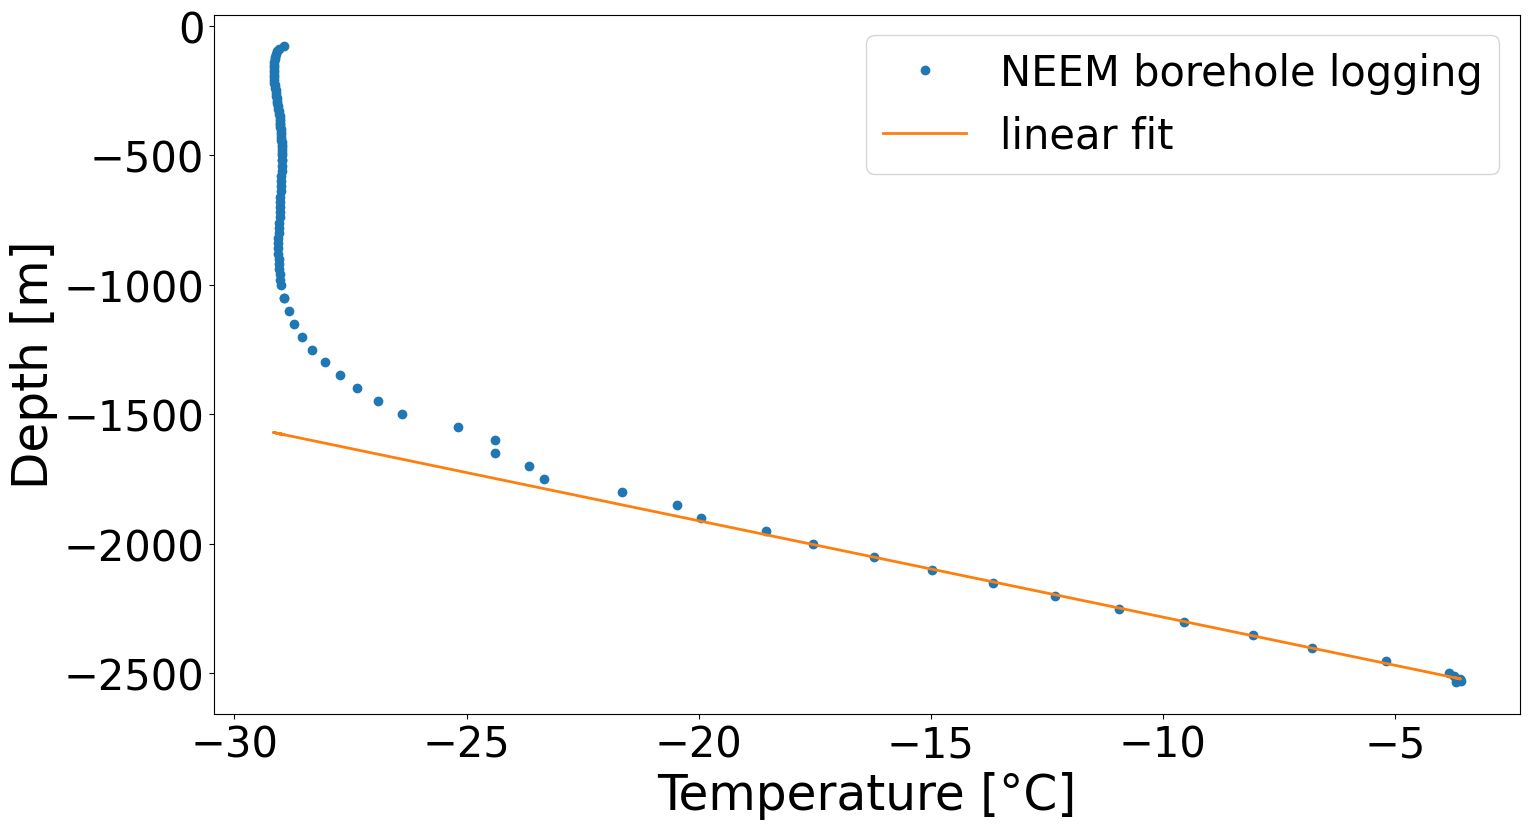

In [13]:
# Read in temperatures and fit for depth >= 2000m
df_temp = pd.read_csv("/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_NEEM/NEEM_TEMP_2015",names=["depth[m]","temperature[°C]"],sep="  ",engine="python")
fig, ax = plt.subplots(figsize=(16, 9))
a,b=np.polyfit(np.array(df_temp["temperature[°C]"])[90:],np.array(df_temp["depth[m]"])[90:],1)
ax.plot(df_temp["temperature[°C]"],-df_temp["depth[m]"],"o",label="NEEM borehole logging")
ax.plot(df_temp["temperature[°C]"],-a*df_temp["temperature[°C]"]-b,lw=2,label="linear fit")
ax.set(xlabel="Temperature [°C]",ylabel="Depth [m]")
ax.legend()
fig.tight_layout()
if saveplot:
    fig.savefig("Plots/18_NEEM_temperature.png",dpi=100)
fig.show()
print(df_temp["depth[m]"].iloc[90])

In [14]:
# Add temperatures to df
for bag in df_xLASM.keys():
    df_xLASM[bag]["temperature[K]"] = (df_xLASM[bag]["depth[m]"]-b)/a+273.15
df_xLASM["nmx3655c"].head()

,crop_image,depth[m],equivalent_diameter[px],grain_size[px],grain_size_err[px],E_1,temperature[K]
0,0,2009.7005,233.333238,1.355862e+06,0,1.696398,255.808693
1,0,2009.7015,229.516607,1.295666e+06,0,1.696484,255.808720
2,0,2009.7025,224.056358,1.236872e+06,0,1.696654,255.808746
3,0,2009.7035,215.872446,1.153831e+06,0,1.696909,255.808773
4,0,2009.7045,211.855080,1.109594e+06,0,1.697248,255.808800


In [15]:
# Shear stress
def shear_stress(z_ice):
    """
    calculate shear stress along ice core by shallow ice approximation
    --------------------------------------------
    param: (arraylike) z_ice: ice thickness/depth [m]
    return: (arraylike) tau_xz: shear stress [MPa]
    """
    tau_xz = rho_ice*z_ice*g*dhdx/1000000
    return tau_xz

for bag in df_xLASM.keys():
    df_xLASM[bag]["tau_xz[MPa]"] = shear_stress(df_xLASM[bag]["depth[m]"]) 

In [16]:
# Calculate E
for bag in df_xLASM.keys():
    df_xLASM[bag]["E_2"] = power_law(df_xLASM[bag]["tau_xz[MPa]"]*np.sqrt(3),A_gbs,n_gbs,df_xLASM[bag]["equivalent_diameter[px]"]*px_to_m,p_gbs,Q_gbs,df_xLASM[bag]["temperature[K]"])/power_law(df_xLASM[bag]["tau_xz[MPa]"]*np.sqrt(3),A_glen,n_glen,df_xLASM[bag]["equivalent_diameter[px]"],p_glen,Q_glen,df_xLASM[bag]["temperature[K]"])
df_xLASM["nmx3655c"].head()

,crop_image,depth[m],equivalent_diameter[px],grain_size[px],grain_size_err[px],E_1,temperature[K],tau_xz[MPa],E_2
0,0,2009.7005,233.333238,1.355862e+06,0,1.696398,255.808693,0.032293,0.774175
1,0,2009.7015,229.516607,1.295666e+06,0,1.696484,255.808720,0.032293,0.792257
2,0,2009.7025,224.056358,1.236872e+06,0,1.696654,255.808746,0.032293,0.819417
3,0,2009.7035,215.872446,1.153831e+06,0,1.696909,255.808773,0.032293,0.863235
4,0,2009.7045,211.855080,1.109594e+06,0,1.697248,255.808800,0.032293,0.886237


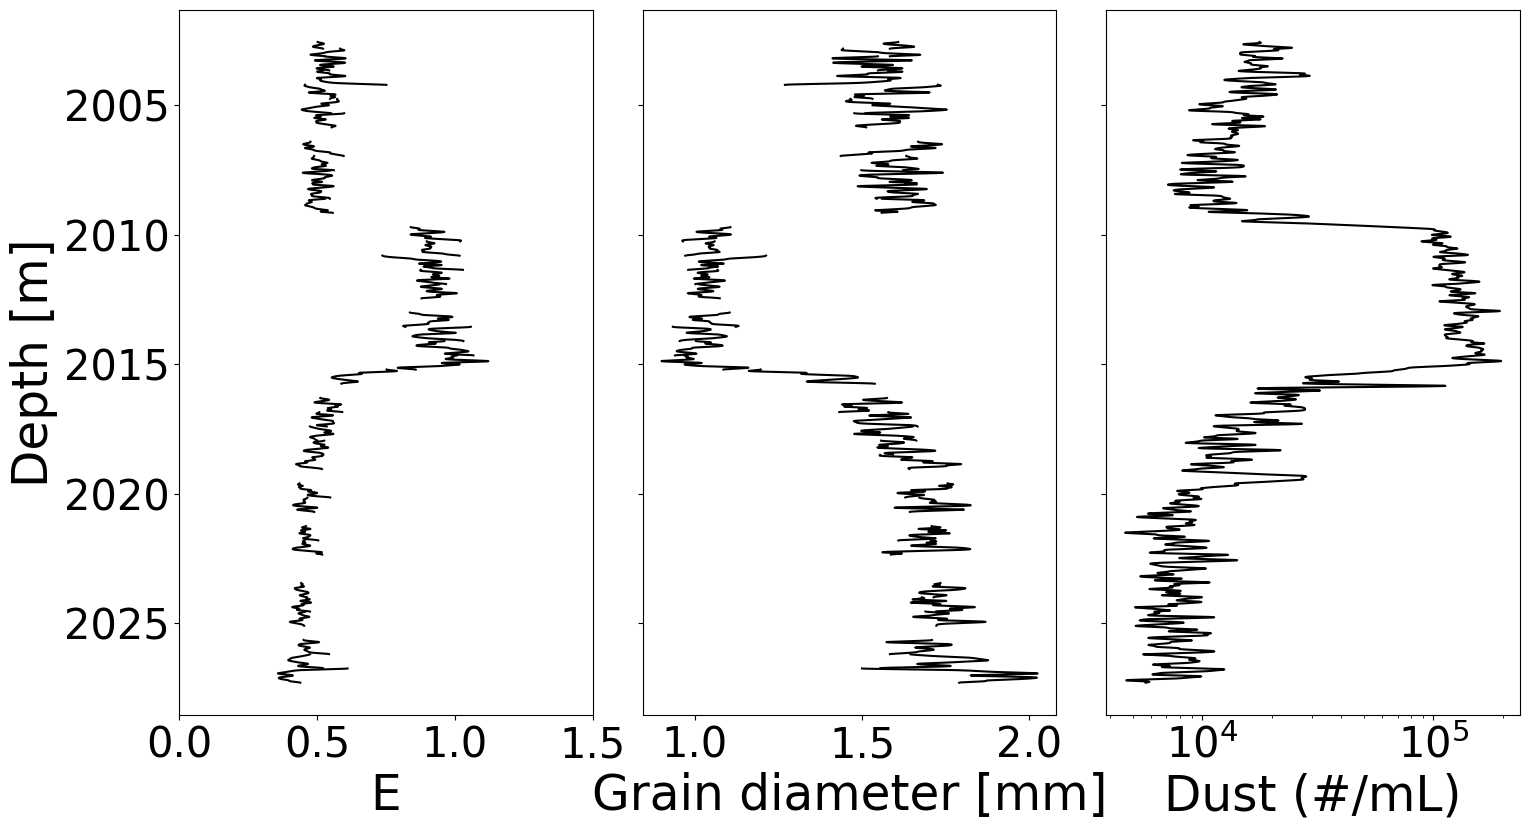

In [17]:
# Plot grain sizes over depth of all images
fig, ax = plt.subplots(1, 3,figsize=(16,9),sharey=True)
for bag in list(df_xLASM.keys()):
    ax[0].plot(gaussian_filter1d(df_xLASM[bag]["E_2"],30),df_xLASM[bag]["depth[m]"],"-",color="black")
    ax[1].plot(gaussian_filter1d(df_xLASM[bag]["equivalent_diameter[px]"]*px_to_m*1000,30),df_xLASM[bag]["depth[m]"],"-",color="black")
#ax[2].plot(gaussian_filter1d(gray_interp["gray_value"],30),gray_interp["depth[m]"],"-",color="black")
ax[2].semilogx(gaussian_filter1d(CFA_interp_slic["Dust (#/mL) [SD>1.0]"],30),CFA_interp_slic["Depth top (m)"],color="black")

ax[0].set(ylabel="Depth [m]",xlabel="E",xlim=(0,1.5))
ax[1].set_xlabel("Grain diameter [mm]")
ax[2].set_xlabel("Dust (#/mL)")

fig.gca().invert_yaxis()
fig.tight_layout()
if saveplot:
    fig.savefig("Plots/18_E_gbs_glen.png",dpi=100)
fig.show()

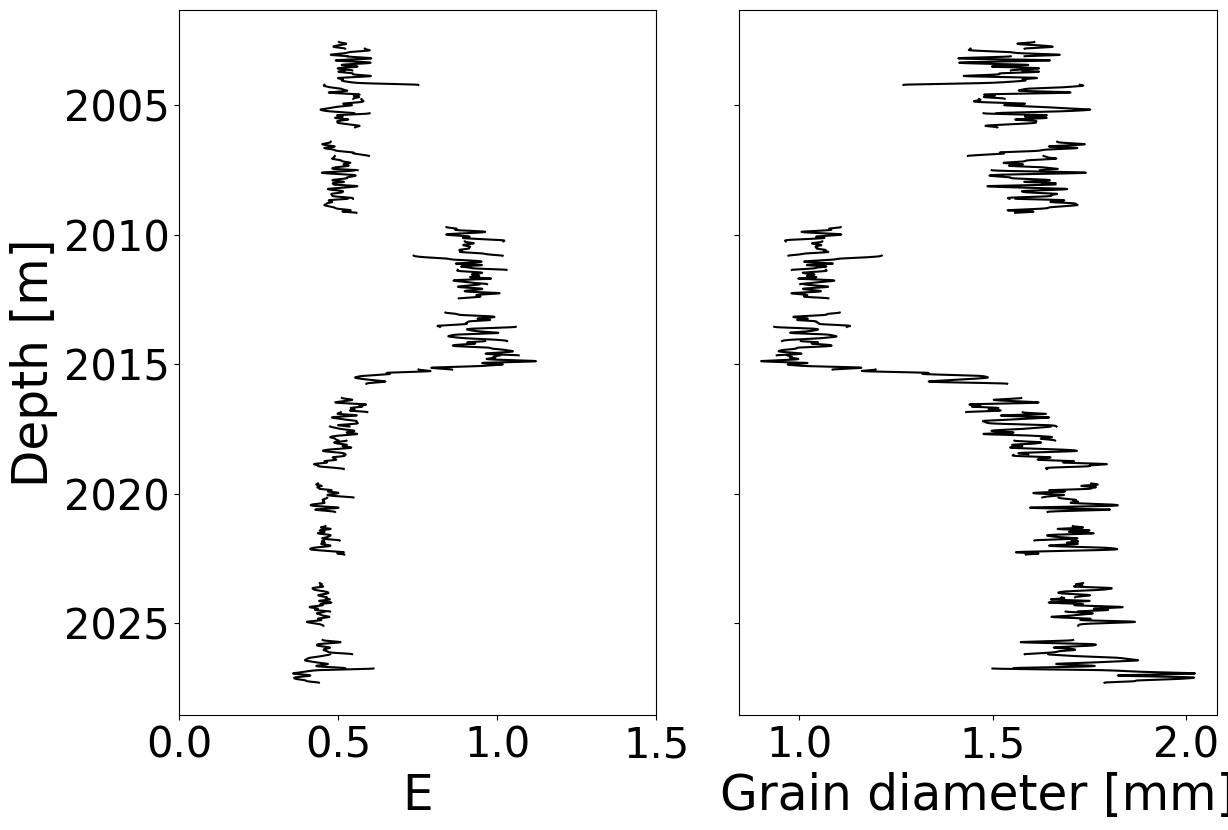

In [19]:
# Plot grain sizes over depth of all images
fig, ax = plt.subplots(1, 2,figsize=(13,9),sharey=True)
for bag in list(df_xLASM.keys()):
    ax[0].plot(gaussian_filter1d(df_xLASM[bag]["E_2"],30),df_xLASM[bag]["depth[m]"],"-",color="black")
    ax[1].plot(gaussian_filter1d(df_xLASM[bag]["equivalent_diameter[px]"]*px_to_m*1000,30),df_xLASM[bag]["depth[m]"],"-",color="black")

ax[0].set(ylabel="Depth [m]",xlabel="E",xlim=(0,1.5))
ax[1].set_xlabel("Grain diameter [mm]")

fig.gca().invert_yaxis()
fig.tight_layout()
if saveplot:
    fig.savefig("Plots/18_E_gbs_glen_defense.png",dpi=100)
fig.show()